## Facial keypoints detection





### Load and preprocess data

6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [0]:
! wget -O facial-keypoints-data.zip 'https://d3c33hcgiwev3.cloudfront.net/LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip?Expires=1558224000&Signature=QvXGx6-Z5Ljq3MNlNwlVyu3vTNTYEFd0L0bRVUS86HI7Iy6~mkQZKMcnAtcaUB2nUJnRlI5L8zUdaQ1bDP-ZFUHmRbXdJAFYFcbM4pfGuu~jB17X2ypWL1471Yr1yZbyuJvIkvRmKc0lCFE0UGvXcHTXp5Z4h9q7KaEdIkU7Mdk_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'

--2019-05-18 17:04:26--  https://d3c33hcgiwev3.cloudfront.net/LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip?Expires=1558224000&Signature=QvXGx6-Z5Ljq3MNlNwlVyu3vTNTYEFd0L0bRVUS86HI7Iy6~mkQZKMcnAtcaUB2nUJnRlI5L8zUdaQ1bDP-ZFUHmRbXdJAFYFcbM4pfGuu~jB17X2ypWL1471Yr1yZbyuJvIkvRmKc0lCFE0UGvXcHTXp5Z4h9q7KaEdIkU7Mdk_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A
Resolving d3c33hcgiwev3.cloudfront.net (d3c33hcgiwev3.cloudfront.net)... 52.84.225.85, 52.84.225.9, 52.84.225.127, ...
Connecting to d3c33hcgiwev3.cloudfront.net (d3c33hcgiwev3.cloudfront.net)|52.84.225.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132893829 (127M) [application/zip]
Saving to: ‘facial-keypoints-data.zip’

facial-keypoints-da 100%[===================>] 126.74M  20.2MB/s    in 8.0s    

2019-05-18 17:04:35 (15.8 MB/s) - ‘facial-keypoints-data.zip’ saved [132893829/132893829]



In [0]:
!ls

facial-keypoints-data.zip  sample_data


In [0]:
!unzip facial-keypoints-data.zip

In [0]:
!ls

facial-keypoints  facial-keypoints-data.zip  __MACOSX  sample_data


Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [0]:
### Useful routines for preparing data
import pandas as pd
import numpy as np
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize



In [0]:
df=pd.read_csv('facial-keypoints/data/gt.csv')

In [0]:
df.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,77,85,75,110,82,160,87,171,79,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,27,34,26,40,28,59,30,68,30,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,115,40,96,47,87,59,60,59,41,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,31,48,34,59,39,79,44,85,43,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,67,52,62,73,64,104,58,115,50,129,49,111,105,72,137,106,132,126,121


In [0]:
images = df.filename

In [0]:
cols=df.columns[1:]
np.array(df[cols])[0]

array([ 51,  51, 127,  60, 169,  65, 203,  52,  68,  77,  85,  75, 110,
        82, 160,  87, 171,  79, 193,  84, 156, 144,  92, 174, 140, 180,
       168, 179])

In [0]:
n=np.array(images)
images.shape

(6000,)

In [0]:
dirname='facial-keypoints'
sf=pd.read_csv(dirname+'/data/gt.csv')
sf.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,77,85,75,110,82,160,87,171,79,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,27,34,26,40,28,59,30,68,30,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,115,40,96,47,87,59,60,59,41,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,31,48,34,59,39,79,44,85,43,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,67,52,62,73,64,104,58,115,50,129,49,111,105,72,137,106,132,126,121


In [0]:
def load_imgs_and_keypoints(dirname='facial-keypoints'):
    # Write your code for loading images and points here
    df=pd.read_csv(dirname+'/data/gt.csv')
    images_names=df.filename
    cols=df.columns[1:]
    points=np.array(df[cols],dtype='float32')
    imgs=[]
    for i,name in enumerate(images_names):
      img = imread(dirname+'/data/images/'+name)
      if(len(img.shape)<3):
        img=gray2rgb(img)
      x,y,_=img.shape
      points[i][::2]=(points[i][::2]/x)-0.5           # normalize x-coordinates
      points[i][1::2]=(points[i][1::2]/y)-0.5         # normalize y-coordinates
      imgs.append(resize(img,(100,100,3)))
    return(imgs,points)
    
    

imgs, points = load_imgs_and_keypoints()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
x=imread('facial-keypoints/data/images/'+images[294])



x=gray2rgb(x)
len(x.shape)

3

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


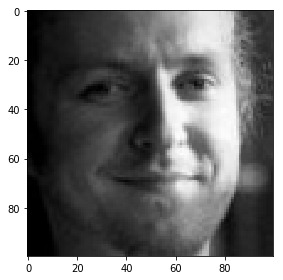

In [0]:
from skimage.io import imshow
x=resize(x,(100,100))
imshow(x)

In [0]:
x.shape

(100, 100, 3)

In [0]:
i=np.array([1,2,3,4,5,6])
i[1::2]=i[1::2]+1
i


array([1, 3, 3, 5, 5, 7])

In [0]:
import numpy as np
a= np.array(['a',1])
a

array(['a', '1'], dtype='<U1')

array([-0.3053435 , -0.3053435 , -0.01526716, -0.27099237,  0.14503819,
       -0.2519084 ,  0.27480918, -0.30152673, -0.24045801, -0.20610687,
       -0.17557251, -0.21374047, -0.08015266, -0.1870229 ,  0.11068702,
       -0.16793892,  0.15267175, -0.19847327,  0.23664123, -0.17938933,
        0.09541982,  0.0496183 , -0.14885497,  0.16412216,  0.03435117,
        0.18702292,  0.14122134,  0.18320608], dtype=float32)

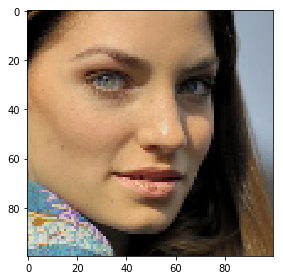

In [0]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image 

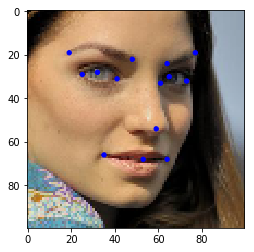

In [0]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
  real_points = np.uint8((points+0.5)*100)
  figure= plt.figure()
  figure=plt.subplot(1, 1, 1)
  plt.imshow(img)
  for i in range(0,28,2):
        point = Circle((real_points[i], real_points[i+1]), radius=1, color='blue')
        figure.add_patch(point)
  
    
visualize_points(imgs[0], points[0])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

[-0.27659574 -0.28723404 -0.11702126 -0.30851063  0.10638297 -0.29787233
  0.35106385 -0.23404256 -0.25531915 -0.21276596 -0.13829789 -0.22340426
 -0.07446808 -0.20212767  0.12765956 -0.18085107  0.22340423 -0.18085107
  0.32978725 -0.14893618 -0.04255319 -0.0106383  -0.17021278  0.14893615
 -0.02127659  0.20212764  0.13829786  0.19148934]
[ 0.3053435  -0.3053435   0.01526716 -0.27099237 -0.14503819 -0.2519084
 -0.27480918 -0.30152673  0.24045801 -0.20610687  0.17557251 -0.21374047
  0.08015266 -0.1870229  -0.11068702 -0.16793892 -0.15267175 -0.19847327
 -0.23664123 -0.17938933 -0.09541982  0.0496183   0.14885497  0.16412216
 -0.03435117  0.18702292 -0.14122134  0.18320608]


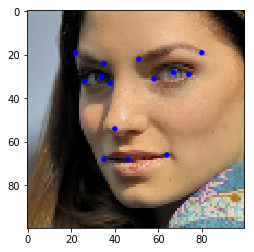

In [0]:
def flip_img(img, points):
    # Write your code for flipping here
    f_img=img[:,::-1,:]
    f_points=points.copy()
    for i in range(0,28,2):
      f_points[i]=-f_points[i]
   
    return f_img,f_points

f_img, f_points = flip_img(imgs[0], points[0])
print(points[1])
print(f_points)
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
aug_imgs_train=[]
aug_points_train=[]
for img,point in zip(imgs_train,points_train):
  aug_img,aug_point=flip_img(img, point)
  aug_imgs_train.append(img)
  aug_imgs_train.append(aug_img)
  aug_points_train.append(point)
  aug_points_train.append(aug_point)

aug_imgs_train=np.array(aug_imgs_train)
aug_points_train=np.array(aug_points_train)
  


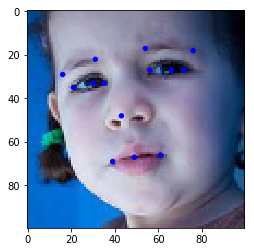

In [0]:
visualize_points(aug_imgs_train[100], aug_points_train[100])

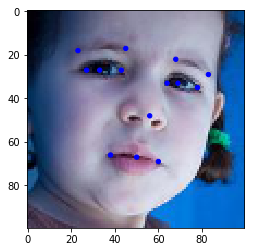

In [0]:
visualize_points(aug_imgs_train[101], aug_points_train[101])

In [0]:
imgs_val=np.array(imgs_val)
points_val =np.array(points_val)

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. 


In [0]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout,BatchNormalization,Activation
)
from keras.optimizers import (Adam,SGD)



model = Sequential()
# Define here your model
model.add(Conv2D(32,kernel_size=(3, 3),input_shape=aug_imgs_train[0].shape,padding="same"))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))


model.add(Conv2D(64,kernel_size=(3, 3),padding="same"))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))




model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(28,activation='tanh'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
adam =Adam(lr=1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(optimizer='adam', loss='mse',metrics=['mse'])

model.fit(aug_imgs_train, aug_points_train,
          batch_size=100,
          epochs=30,
          verbose=1,shuffle=True,
          validation_data=(imgs_val,points_val))



Train on 10800 samples, validate on 600 samples
Epoch 1/30
10800/10800 [==============================] - 10s 882us/step - loss: 0.0951 - mean_squared_error: 0.0951 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 2/30
10800/10800 [==============================] - 6s 557us/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 3/30
10800/10800 [==============================] - 6s 555us/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 4/30
10800/10800 [==============================] - 6s 561us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 5/30
10800/10800 [==============================] - 6s 563us/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 6/30
10800/10800 [==============================] - 6s 572us/step - loss: 0.0157 - mean_squared_error: 0.

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[-0.32872486 -0.30219716 -0.1308787  -0.31298637  0.07630676 -0.30470276
  0.3059705  -0.29539517 -0.27255008 -0.20691265 -0.18142855 -0.2206283
 -0.11155859 -0.20836872  0.10360717 -0.19180234  0.19212908 -0.2062314
  0.2688442  -0.19935577 -0.02851196  0.00475141 -0.12119174  0.20449327
 -0.00667941  0.20999761  0.14637361  0.20704085]
[-0.33006537 -0.24509802 -0.16666666 -0.2777778   0.07516342 -0.30392158
  0.30392158 -0.29738563 -0.2647059  -0.16666666 -0.19281045 -0.19281045
 -0.11437908 -0.1862745   0.09477127 -0.1993464   0.17973858 -0.21895424
  0.251634   -0.21895424 -0.02287582  0.0163399  -0.11437908  0.20588237
 -0.00980392  0.21895427  0.12091506  0.20588237]


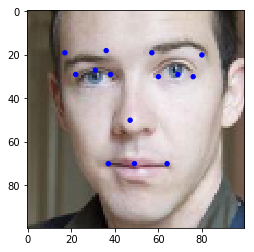

In [0]:
pred_points = model.predict(imgs_val)[120]
visualize_points(imgs_val[120], pred_points)
print(pred_points)
print(points_val[120])

[-0.21479379 -0.35418272 -0.06194386 -0.32803673  0.07967797 -0.3030846
  0.19850974 -0.27858415 -0.17171817 -0.24902064 -0.12789913 -0.2427108
 -0.07311989 -0.21208823  0.07414207 -0.19701411  0.12383919 -0.21342538
  0.17680025 -0.19497505 -0.00914053  0.01761671 -0.05490461  0.20899872
 -0.00558491  0.22308084  0.08720872  0.23718412]
[-0.18618989 -0.29654747 -0.09309494 -0.29038227  0.1220715  -0.28729963
  0.29284835 -0.20961776 -0.15289766 -0.22749692 -0.12946978 -0.22749692
 -0.09926018 -0.22749692  0.13131934 -0.1917386   0.17940813 -0.17077681
  0.23304564 -0.15598026 -0.12638718  0.01171392 -0.10234278  0.1701603
 -0.03020963  0.2003699   0.10110974  0.21208388]


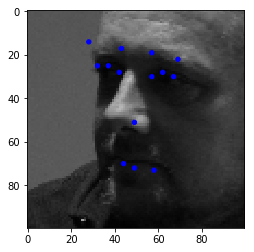

In [0]:
pred_points = model.predict(imgs_val)[50]
visualize_points(imgs_val[50], pred_points)
print(pred_points)
print(points_val[50])

[-0.36035374 -0.23604064 -0.12391218 -0.26924452  0.12570104 -0.29479155
  0.34684074 -0.31455794 -0.29103598 -0.15515265 -0.19490919 -0.17375752
 -0.12679708 -0.17380457  0.13846546 -0.19188063  0.2194344  -0.21325141
  0.30207404 -0.21617079  0.03748517  0.02103342 -0.1318768   0.19707404
  0.03083611  0.19483346  0.17749508  0.17134333]
[-0.34051722 -0.27586207 -0.15086207 -0.27586207 -0.01293105 -0.29310346
  0.24568963 -0.37931034 -0.35775864 -0.13793105 -0.23706895 -0.13793105
 -0.15086207 -0.13793105  0.1939655  -0.18965518  0.22844827 -0.18965518
  0.29741377 -0.18965518  0.09051722  0.         -0.11637932  0.18965518
  0.02155173  0.10344827  0.15948278  0.12068963]


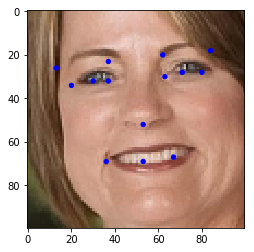

In [0]:
pred_points = model.predict(imgs_val)[20]
visualize_points(imgs_val[20], pred_points)
print(pred_points)
print(points_val[20])